# **A geocomputational notebook to monitor regional development in Bolivia**

Carlos Mendez (Nagoya Univerisity), Erick Gonzales (United Nations), Lykke Andersen (SDSN Bolivia)

![](https://github.com/quarcs-lab/project2021o-notebook/blob/main/figs/cover.png?raw=true)

## 1) Setup

In [139]:
# Adding necessary libraries to Google Colab environment

# Installing the 'contextily' library for adding basemaps to plots
!pip install contextily -q

# Installing the 'splot' library for spatial data visualization
!pip install splot -q

# Installing the 'inequality' library for inequality analysis
!pip install inequality -q

# Installing the 'mgwr' library for performing geographically weighted regression
!pip install mgwr -q


In [140]:
# Importing necessary libraries for data analysis and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go

# Importing libraries for spatial data and visualization
import geopandas as gpd
import contextily as cx

import libpysal
from libpysal  import weights
from libpysal.weights import Queen

# Exploratory Spatial Data Analysis (ESDA) tools
import esda
from esda.moran import Moran, Moran_Local

# Spatial plotting tools
import splot
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster, plot_local_autocorrelation
from splot.libpysal import plot_spatial_weights
from splot.mapping import vba_choropleth

# Library for inequality analysis
import inequality
from inequality.gini import Gini_Spatial

# Statistical modeling
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Geographically Weighted Regression (GWR) and related utilities
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
from mgwr.utils import shift_colormap, truncate_colormap

# Suppressing warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')


## 2) Import data

In [141]:
dataURL = 'https://gist.github.com/cmg777/788a6c962f2d8f217ca44ff5dc567b5c/raw/ad1e0fd5b086eab7d90f5ba126c7839d4940f2e1/GeoDS4Bolivia.geojson'
gdf = gpd.read_file(dataURL)

In [186]:
gdf.head(3)

asdf_id               shapeName    COORD_X    COORD_Y  poly_id  \
0        0               Esmeralda -68.086369 -18.945744      178   
1        1  Santuario de Quillacas -66.813557 -19.318918      169   
2        2          Pampa Aullagas -67.165981 -19.231799      185   

              mun  mun_id    dep  dep_id               dep_mun  \
0       Esmeralda   40505  Oruro       5       Oruro-Esmeralda   
1       Quillacas   40202  Oruro       5       Oruro-Quillacas   
2  Pampa Aullagas   40802  Oruro       5  Oruro-Pampa Aullagas   

                      shapeID       imds  rank_imds  population_2020  \
0  BOL-ADM3-33444609B20338026  53.200001        108             2854   
1  BOL-ADM3-33444609B53994240  50.500000        171             4474   
2  BOL-ADM3-33444609B27878331  47.299999        246             2852   

   urbano_2012 sdg1_1_eepr  sdg1_1_ubn  sdg1_2_mpi  sdg1_4_abs  sdg2_2_cmc  \
0            0         NaN   78.300003        0.10   10.800000   19.200001   
1            0   88.300003   73.599998        0.15   19.299999   31.500000   
2            0   96.699997   85.199997        0.19   12.300000   31.500000   

   sdg2_2_oww  sdg2_4_pual  sdg2_4_td  sdg3_1_idca  sdg3_2_imr  sdg3_2_mrc  \
0        20.6    47.099998        0.0    43.200001   28.700001   34.700001   
1        19.5     7.700000       87.0    41.000000   48.599998   64.599998   
2        19.5    33.599998      111.0    33.700001   40.299999   52.700001   

   sdg3_3_cdir  sdg3_3_di  sdg3_3_imr  sdg3_3_ti  sdg3_3_hivi  sdg3_7_afr  \
0            0          0           0          0            0          14   
1            0          0           0         23            0          55   
2            0          0           0         34            0          55   

   sdg4_1_ssdrm  sdg4_1_ssdrf  sdg4_4_phe  sdg4_6_lr  sdg4_c_qti  sdg4_c_qts  \
0             0             0        11.8  97.800003          40   53.599998   
1             1             0        12.1  94.800003          33   25.000000   
2             1             1         9.4  92.599998           0   29.400000   

   sdg5_1_gpsd  sdg5_1_gpyp  sdg5_1_gpmpi  sdg5_5_gpop  sdg6_1_dwc  sdg6_2_sc  \
0            1            1           0.6          0.6   95.500000         15   
1            2            0           1.2          0.9   60.500000         25   
2            2            0           1.1          0.7   66.199997         19   

   sdg6_3_wwt  sdg7_1_ec  sdg7_1_rec  sdg7_1_cce  sdg7_3_co2epc sdg8_4_rem  \
0           0  82.400002           2          37            0.1        NaN   
1           0  64.599998          27          49            0.2       18.1   
2           0  64.500000           9          34            0.1  41.599998   

   sdg8_5_oprm  sdg8_5_ofrm  sdg8_6_mlm  sdg8_6_wlm  sdg8_10_dbb  sdg8_11_idi  \
0    68.500000    43.900002        14.7   26.200001            0            0   
1    78.699997    67.400002         6.8   14.700000            0            0   
2    70.900002    51.700001         7.3   22.200001            0            0   

   sdg9_1_routes  sdg9_5_cd sdg9_5_eutf  sdg9_c_mnc  sdg9_c_drb  sdg10_2_gcye  \
0              1          0         NaN          52         0.4          0.28   
1              2          3   18.200001          45         2.8          0.35   
2              0          4        12.5          43         3.4          0.39   

  sdg10_2_iec  sdg10_2_nssp  sdg11_1_hocr  sdg11_1_hno  sdg11_2_samt  \
0         NaN      8.100000     44.099998    87.699997         552.5   
1          30     16.700001     22.400000    77.199997           0.0   
2          11     13.500000     27.200001    82.099998           0.0   

   sdg13_1_ccvi  sdg13_2_tco2e  sdg13_2_dra  sdg15_1_pa  sdg15_5_blr  \
0             2            0.1            0           0            0   
1             2            0.2            0           0            0   
2             2            0.1            0           0            0   

   sdg16_1_rhr  sdg16_6_pbec  sdg16_9_cr  sdg17_1_

In [143]:
dataDefinitions = pd.read_csv('https://gist.githubusercontent.com/cmg777/979285c2bcde9832dd9cc0ee0fe9062d/raw/c4befc87572a744a7cd66b54ac233412a5f4ec2f/DataDefinitions.csv')
dataDefinitions

Variable                                   Label
0         poly_id                              Polygon ID
1         asdf_id                                 ASDF ID
2             mun                            Municipality
3          mun_id                         Municipality ID
4             dep                              Department
..            ...                                     ...
134  tr400_co2016  Trend estimated carbon dioxide in 2016
135  tr400_co2017  Trend estimated carbon dioxide in 2017
136  tr400_co2018  Trend estimated carbon dioxide in 2018
137  tr400_co2019  Trend estimated carbon dioxide in 2019
138  tr400_co2020  Trend estimated carbon dioxide in 2020

[139 rows x 2 columns]

## 3) Select key indicators

In [144]:
INDICATOR1 = 'imds'

In [145]:
INDICATOR2 = 'pop2017'

In [146]:
INDICATOR3 = 'ln_t400NTLpc2017'

In [147]:
INDICATOR4 = 'co2017'

In [148]:
gdf[['mun', 'dep', INDICATOR1, INDICATOR2, INDICATOR3, INDICATOR4]]

mun         dep       imds     pop2017  ln_t400NTLpc2017  \
0         Esmeralda       Oruro  53.200001   4065.6479         12.987050   
1         Quillacas       Oruro  50.500000   4517.6450         13.552914   
2    Pampa Aullagas       Oruro  47.299999   2951.3447         13.044642   
3         Llallagua      Potosí  58.099998  43508.5940         14.755211   
4          Caripuyo      Potosí  43.500000   9163.9531         12.426621   
..              ...         ...        ...         ...               ...   
334        Pasorapa  Cochabamba  56.799999   7985.2656         12.471334   
335       Cotagaita      Potosí  47.599998  34884.8280         13.154016   
336         Camargo  Chuquisaca  53.000000  17155.0270         13.570594   
337        Villazón      Potosí  62.000000  50735.9020         14.243058   
338         Padcaya      Tarija  59.299999  18673.8070         14.213583   

        co2017  
0    404.97272  
1    404.49866  
2    403.60504  
3    404.03146  
4    403.43185  
..         ...  
334  402.32376  
335  403.30103  
336  402.73300  
337  403.78232  
338  402.87421  

[339 rows x 6 columns]

## 4) Exploratory data analysis (EDA)

### 4.1) Descriptive statistics

- What do we know about the centrality and dispersion of our development indicator?

In [149]:
gdf[[INDICATOR1, INDICATOR2, INDICATOR3, INDICATOR4]].describe().round(2)

imds     pop2017  ln_t400NTLpc2017  co2017
count  339.00      339.00            339.00  339.00
mean    51.05    32858.76             13.67  403.59
std      6.77   117649.33              1.28    1.23
min     35.70      661.82              7.87  400.05
25%     47.00     6425.71             12.82  402.91
50%     50.50    11627.51             13.70  403.67
75%     54.85    22497.26             14.65  404.56
max     80.20  1604457.50             16.99  406.23

### 4.2) Regional development differences

- How is our development indicator disbributed across the 339 municipalities and 9 departments of Bolivia?

In [189]:
# Creating a strip plot using Plotly Express
px.strip(
    gdf,
    x=INDICATOR1,                    # Data for x-axis
    y='dep',                         # Data for y-axis
    color='dep',                     # Color grouping based on 'dep'
    hover_name='mun',                # Municipality for hover tooltip
    hover_data=['rank_imds'],        # Additional data for hover tooltip
    labels=dict(
        imds='Sustainable development index',  # Label for x-axis
        rank_imds='Development ranking',        # Label for hover data
        mun='Municipality',                     # Label for hover data
        dep='Department'                        # Label for y-axis
    )
)


In [190]:
# Creating a box plot using Plotly Express
px.box(
    gdf,
    x=INDICATOR1,                    # Data for x-axis
    y='dep',                         # Data for y-axis
    color='dep',                     # Color grouping based on 'dep'
    hover_name='mun',                # Municipality for hover tooltip
    hover_data=['rank_imds'],        # Additional data for hover tooltip
    labels=dict(
        imds='Sustainable development index',  # Label for x-axis
        rank_imds='Development ranking',        # Label for hover data
        mun='Municipality',                     # Label for hover data
        dep='Department'                        # Label for y-axis
    )
)

In [191]:
# Creating a histogram using Plotly Express
px.histogram(
    gdf,
    x=INDICATOR1,                    # Data for x-axis
    color='dep',                     # Color grouping based on 'dep'
    hover_name='mun',                # Municipality for hover tooltip
    marginal='rug',                  # Display rug plot on the marginal axis
    hover_data=['rank_imds'],        # Additional data for hover tooltip
    labels=dict(
        imds='Sustainable development index',  # Label for x-axis
        rank_imds='Development ranking',        # Label for hover data
        mun='Municipality',                     # Label for hover data
        dep='Department'                        # Label for y-axis
    )
)


### 4.3) Population and development

- Do the most populous regions tend to be more developed?

In [192]:
# Creating a treemap using Plotly Express
px.treemap(
    gdf,
    color=INDICATOR1,                # Data for coloring
    values="pop2020",                # Data for size of treemap blocks
    path=["dep", "mun"],             # Path for hierarchical display
    hover_name="mun",                # Municipality for hover tooltip
    hover_data=['rank_imds'],        # Additional data for hover tooltip
    labels=dict(
        imds='Development',            # Label for color coding
        rank_imds='Development ranking',  # Label for hover data
        pop2020='Population in 2020',  # Label for treemap block size
        mun='Municipality',            # Label for hover data
        dep='Department'               # Label for path components
    )
)

In [193]:
# Creating a sunburst plot using Plotly Express
px.sunburst(
    gdf,
    color=INDICATOR1,                # Data for coloring
    values="pop2020",                # Data for size of sunburst segments
    path=["dep", "mun"],             # Path for hierarchical display
    hover_name="mun",                # Municipality for hover tooltip
    hover_data=['rank_imds'],        # Additional data for hover tooltip
    labels=dict(
        imds='Development',            # Label for color coding
        rank_imds='Development ranking',  # Label for hover data
        pop2020='Population in 2020',  # Label for sunburst segment size
        mun='Municipality',            # Label for hover data
        dep='Department'               # Label for path components
    )
)

### 4.4) Nighttime lights and development

- Can nighttime lights help us predict regional development?

In [194]:
# Creating a scatter plot with Plotly Express
px.scatter(
    gdf,
    x=INDICATOR3,                            # Data for x-axis
    y=INDICATOR1,                            # Data for y-axis
    color='dep',                             # Data for color coding
    symbol='dep',                            # Data for symbol coding
    hover_name='mun',                        # Municipality for hover tooltip
    trendline='ols',                         # Adding OLS trendline
    trendline_scope='overall',               # Scope of the trendline (overall)
    hover_data=['rank_imds'],                # Additional data for hover tooltip
    labels=dict(
        imds='Sustainable development index',     # Label for y-axis
        rank_imds='Development ranking',           # Label for hover data
        ln_t400NTLpc2017='Trend (log) nighttime lights per capita',  # Label for x-axis
        mun='Municipality',                        # Label for hover data
        dep='Department'                           # Label for symbol and color coding
    )
)


How heterogeneious is the relatinship between regional development and nighttime lights?

In [195]:
# Creating a scatter plot with marginal box plots using Plotly Express
px.scatter(
    gdf,
    x=INDICATOR3,                             # Data for x-axis
    y=INDICATOR1,                             # Data for y-axis
    color='dep',                              # Data for color coding
    symbol='dep',                             # Data for symbol coding
    hover_name='mun',                         # Municipality for hover tooltip
    trendline='ols',                          # Adding OLS trendline
    marginal_x="box",                         # Display marginal box plot on x-axis
    marginal_y="box",                         # Display marginal box plot on y-axis
    hover_data=['rank_imds'],                 # Additional data for hover tooltip
    labels=dict(
        imds='Sustainable development index',     # Label for y-axis
        rank_imds='Development ranking',           # Label for hover data
        ln_t400NTLpc2017='Trend (log) nighttime lights per capita',  # Label for x-axis
        mun='Municipality',                        # Label for hover data
        dep='Department'                           # Label for symbol and color coding
    )
)


## 5) Exploratory spatial data analysis (ESDA)

### 5.1) Spatial distribution

In [196]:
# Exploring data using the explore() function on the GeoDataFrame
gdf.explore(
    column=INDICATOR1,                 # Column to visualize
    tooltip=['dep', 'mun', 'imds', 'rank_imds'],  # Information to show in tooltip
    k=3,                               # Number of classes for visualization
    scheme='FisherJenks',              # Classification scheme
    cmap='coolwarm',                   # Color map for visualization
    legend=True,                       # Show legend
    tiles='Stamen Terrain',            # Basemap style
    style_kwds=dict(color="gray", weight=0.4),  # Styling for non-highlighted areas
    legend_kwds=dict(colorbar=False)   # Legend customization
)


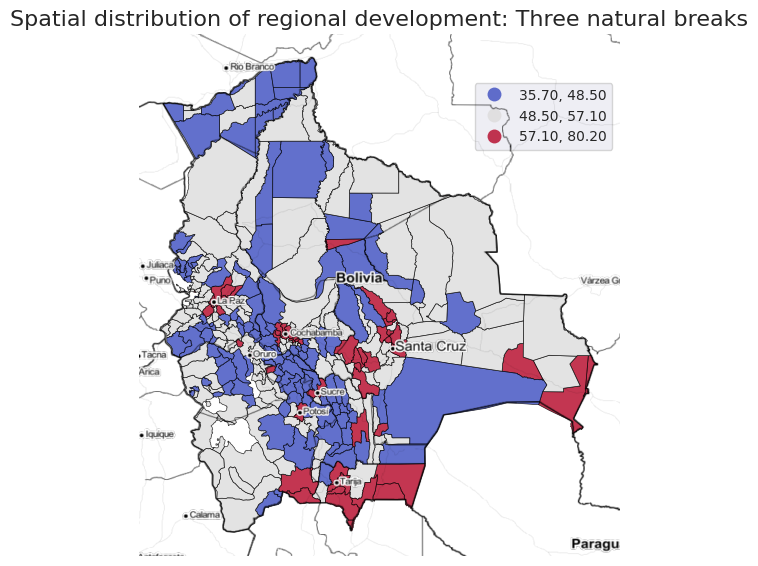

In [197]:
import contextily as cx

# Create a figure and axis for plotting
fig, ax = plt.subplots(figsize=(9, 6))

# Plot the GeoDataFrame with specified settings
gdf.plot(
    column=INDICATOR1,              # Data for coloring
    scheme='FisherJenks',           # Classification scheme
    k=3,                            # Number of classes for coloring
    cmap='coolwarm',                # Color map for visualization
    edgecolor='k',                  # Color of edges
    linewidth=0.5,                  # Width of edge lines
    alpha=0.8,                      # Transparency
    legend=True,                    # Show legend
    ax=ax,                          # Specify the axis for plotting
    legend_kwds={'bbox_to_anchor': (1.00, 0.92)}  # Legend customization
)

# Adding a basemap using contextily
cx.add_basemap(
    ax,                             # Axis to add basemap to
    crs=gdf.crs.to_string(),         # Coordinate reference system
    source=cx.providers.Stamen.TonerHybrid,  # Basemap source
    attribution=False               # Disable attribution
)

# Set plot title and adjust layout
plt.title('Spatial distribution of regional development: Three natural breaks')
plt.tight_layout()

# Turn off axis display
ax.axis("off")

# Display the plot
plt.show()


### 5.2) Spatial dependence

- To what extent is the performance of a region similar to that of its neighbours?
- To what extent is there is an overall pattern of "clustering"?
- Where can we find statistically significant spatial clusters?
- Where can we find statistically significant spatial outliers?

(<Figure size 1000x1000 with 1 Axes>, <Axes: >)

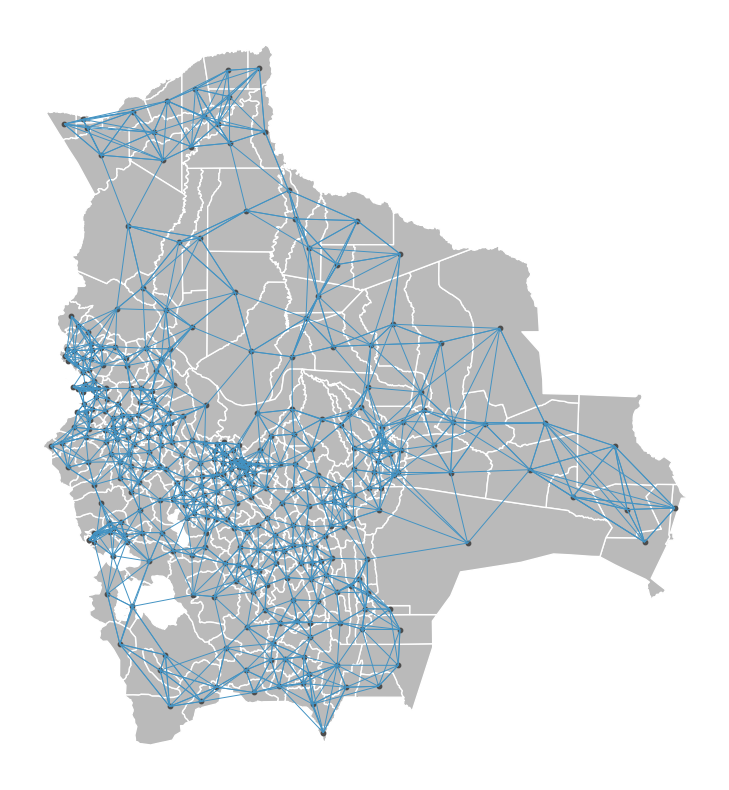

In [199]:
# Create K-nearest neighbors spatial weights
W = weights.KNN.from_dataframe(gdf, k=6)

# Transform the weights to row-standardized
W.transform = 'r'

# Plot the spatial weights using splot
plot_spatial_weights(W, gdf)

In [160]:
# List of columns to select from the GeoDataFrame
myLIST = ['asdf_id', 'mun', 'dep', 'dep_mun', INDICATOR1]
# Create a new DataFrame with selected columns
df_MORAN = gdf[myLIST]
# Calculate spatial lag of INDICATOR1 using the specified weights
df_MORAN["WxINDICATOR1"] = weights.lag_spatial(W, df_MORAN.iloc[: , -1])

In [200]:
# Creating a scatter plot with Plotly Express
px.scatter(
    df_MORAN,
    x=INDICATOR1,                            # Data for x-axis
    y="WxINDICATOR1",                        # Data for y-axis
    hover_name="mun",                        # Municipality for hover tooltip
    hover_data=['dep', INDICATOR1, 'WxINDICATOR1'],  # Additional data for hover tooltip
    trendline="ols",                         # Adding OLS trendline
    marginal_x="box",                        # Display marginal box plot on x-axis
    marginal_y="box",                        # Display marginal box plot on y-axis
    labels=dict(
        imds='Development index',             # Label for y-axis
        WxINDICATOR1='Development index in neighboring regions',  # Label for x-axis
        rank_imds='Development ranking',      # Label for hover data
        mun='Municipality',                   # Label for hover data
        dep='Department'                      # Label for hover data
    )
)


In [203]:
# Calculate global Moran's I
globalMoran = Moran(gdf[INDICATOR1], W)
MoranI = globalMoran.I
MoranI = "{:.2f}".format(MoranI)

# Calculate local indicators of spatial association
localMoran = Moran_Local(gdf[INDICATOR1], W, permutations = 999, seed=12345)

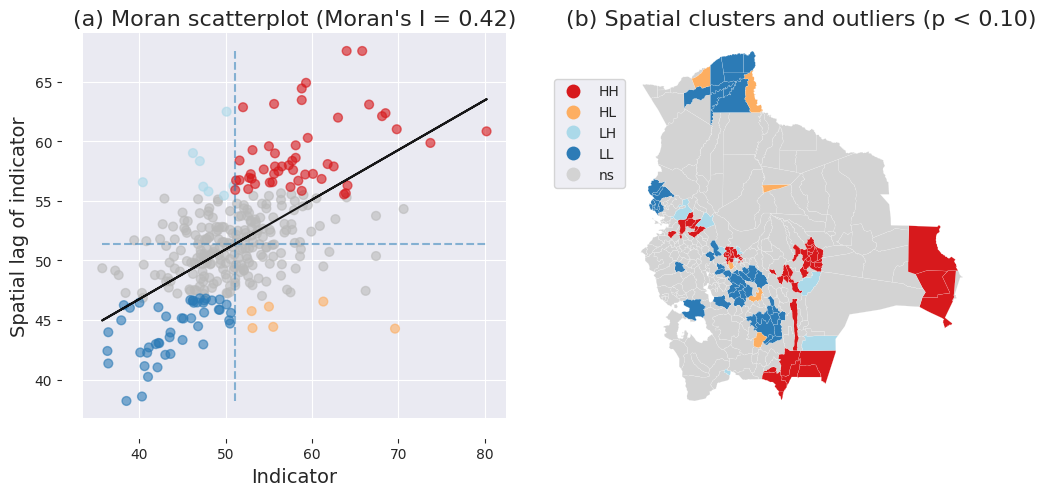

In [201]:
# Create subplots for visualizations
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Plotting Moran scatterplot
moran_scatterplot(localMoran, p=0.10, aspect_equal=False, zstandard=False, ax=axes[0])

# Plotting Local Indicators of Spatial Association (LISA) clusters
lisa_cluster(localMoran, gdf, p=0.10, legend_kwds={'bbox_to_anchor': (0.02, 0.90)}, ax=axes[1])

# Setting labels and titles for the plots
axes[0].set_xlabel('Indicator')
axes[0].set_ylabel('Spatial lag of indicator')
axes[0].set_title(f"(a) Moran scatterplot (Moran's I = {MoranI})")
axes[1].set_title("(b) Spatial clusters and outliers (p < 0.10)")

# Display the plots
plt.show()

### 5.3) Spatial inequality

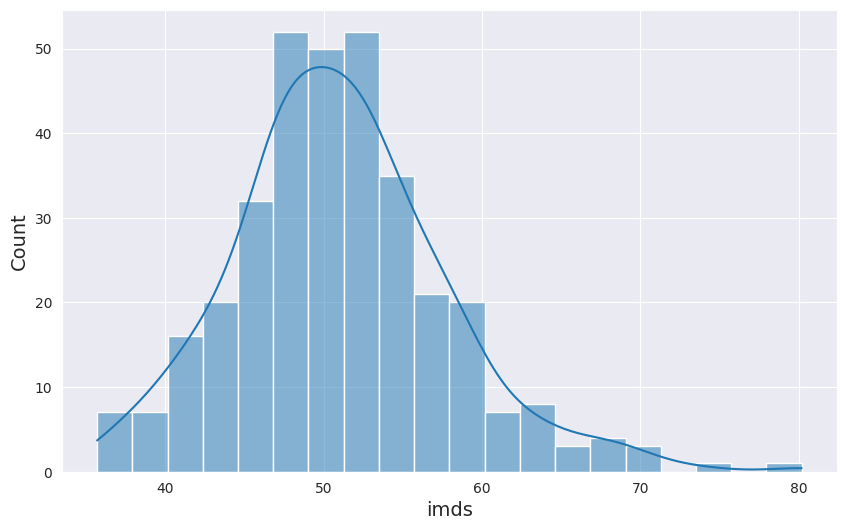

In [164]:
# Create a histogram plot using Seaborn
sns.histplot(x=gdf[INDICATOR1], kde=True);

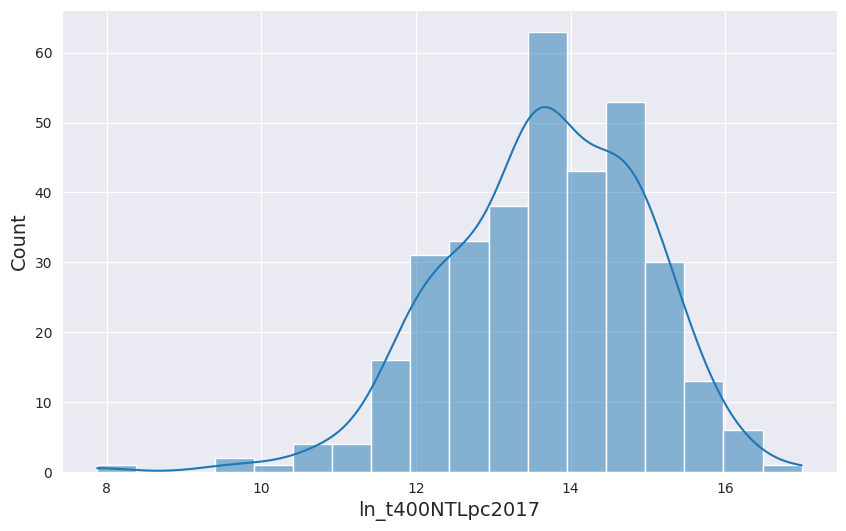

In [204]:
# Create a histogram plot using Seaborn
sns.histplot(x=gdf[INDICATOR3], kde=True);

Let's compute the standard gini index

In [166]:
inequality.gini.Gini(gdf[INDICATOR1].values).g

0.07282132196446878

In [167]:
inequality.gini.Gini(gdf[INDICATOR3].values).g

0.0521407680211148

Let's compute the spatial gini index

In [168]:
Gini_Spatial(gdf[INDICATOR1], W).wcg_share

0.07220311958338523

In [169]:
Gini_Spatial(gdf[INDICATOR1], W).p_sim

0.01

In [170]:
Gini_Spatial(gdf[INDICATOR3], W).wcg_share

0.051704979391114896

In [171]:
Gini_Spatial(gdf[INDICATOR3], W).p_sim

0.01

### 5.4) Spatial heterogeneity

In [172]:
# Reshape the data for GWR regression
y = gdf[INDICATOR1].values.reshape((-1,1))
x = gdf[INDICATOR3].values.reshape((-1,1))

In [173]:
# Create coordinate pairs
u = gdf['COORD_X']
v = gdf['COORD_Y']
coords = list(zip(u,v))

In [205]:
# Perform bandwidth selection for Geographically Weighted Regression (GWR)
gwr_selector = Sel_BW(coords, y, x, spherical = True)
gwr_bw = gwr_selector.search(criterion='AICc')

In [175]:
print('GWR bandwidth =', gwr_bw)

GWR bandwidth = 46.0


In [206]:
# Perform Geographically Weighted Regression (GWR) and get results
gwr_results = GWR(coords, y, x, gwr_bw).fit()

# Display summary of GWR results
gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                 339
Number of covariates:                                                     2

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                          10221.458
Log-likelihood:                                                   -1058.379
AIC:                                                               2120.757
AICc:                                                              2122.829
BIC:                                                               8258.096
R2:                                                                   0.341
Adj. R2:                                                              0.339

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [177]:
# As reference, here is the (mean) R2, AIC, and AICc
print('Mean R2 =', gwr_results.R2)
print('AIC =',     gwr_results.aic)
print('AICc =',    gwr_results.aicc)

Mean R2 = 0.6040381097677936
AIC = 2021.188267111759
AICc = 2031.4418021891354


In [178]:
# Add R2 to GeoDataframe
gdf['gwr_R2'] = gwr_results.localR2

In [207]:
# Visualizing local R-squared using the explore() function
gdf.explore(
    column='gwr_R2',                   # Column to visualize
    tooltip=['dep', 'mun', 'gwr_R2',   # Information to show in tooltip
             'rank_imds', INDICATOR1, INDICATOR3],  # Additional attributes
    k=5,                               # Number of classes for visualization
    scheme='FisherJenks',              # Classification scheme
    cmap='coolwarm',                   # Color map for visualization
    legend=True,                       # Show legend
    tiles='CartoDB dark_matter',       # Basemap style
    style_kwds=dict(color="gray", weight=0.4),  # Styling for non-highlighted areas
    legend_kwds=dict(colorbar=False)   # Legend customization
)


In [180]:
# Add coefficients to data frame
gdf['gwr_intercept'] = gwr_results.params[:,0]
gdf['gwr_slope']     = gwr_results.params[:,1]

In [181]:
# Filter t-values: standard alpha = 0.05
gwr_filtered_t = gwr_results.filter_tvals(alpha = 0.05)

In [182]:
# Filter t-values: corrected alpha due to multiple testing
gwr_filtered_tc = gwr_results.filter_tvals()

In [188]:
# Slope heterogeneity exploration using geopandas' explore() function
gdf.explore(
    column='gwr_slope',                   # Column to visualize
    tooltip=['dep', 'mun', 'gwr_slope',   # Information to show in tooltip
             'rank_imds', INDICATOR1, INDICATOR3],  # Additional attributes
    k=5,                                  # Number of classes for visualization
    scheme='FisherJenks',                 # Classification scheme
    cmap='coolwarm',                      # Color map for visualization
    legend=True,                          # Show legend
    tiles='CartoDB dark_matter',          # Basemap style
    style_kwds=dict(color="gray", weight=0.4),  # Styling for non-highlighted areas
    legend_kwds=dict(colorbar=False)      # Legend customization
)


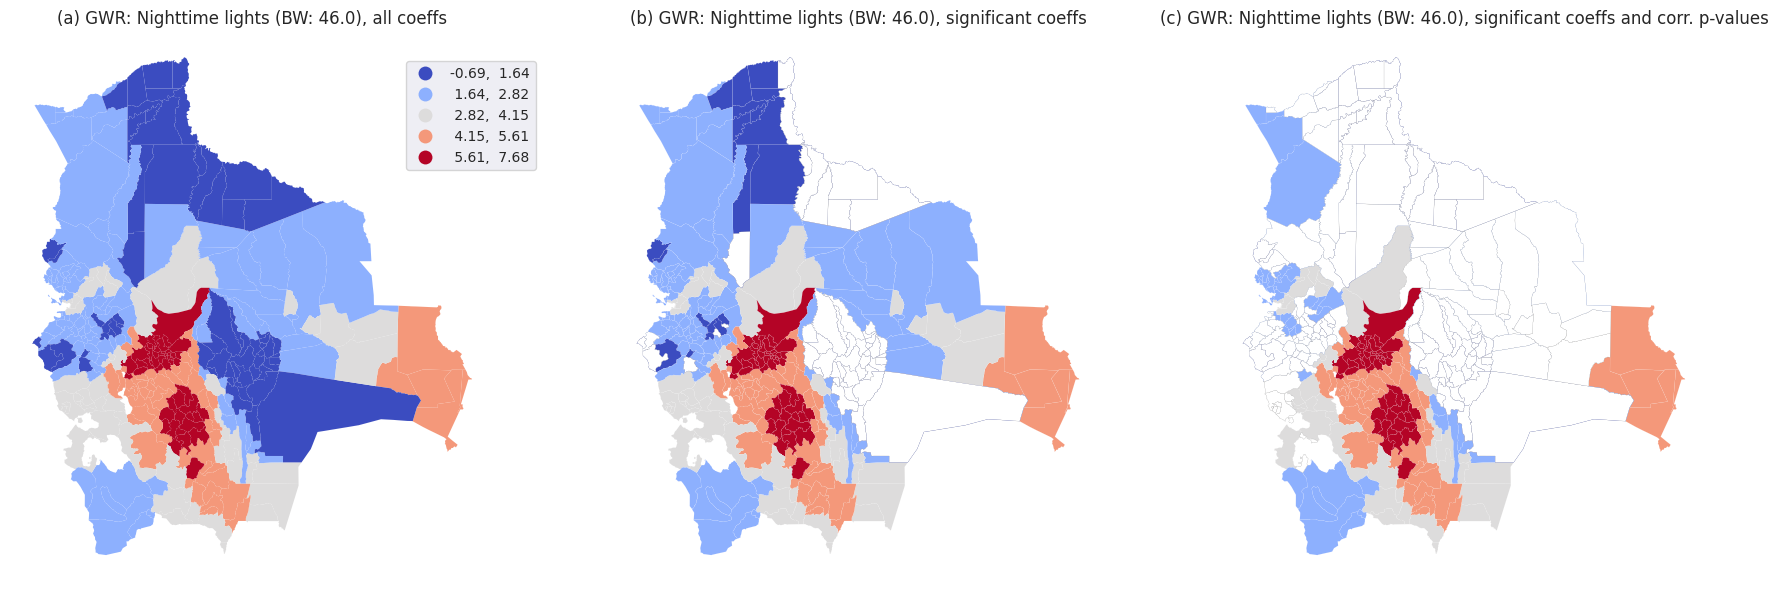

In [187]:
# Create subplots for visualizations
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# Plotting the first map
gdf.plot(column='gwr_slope', cmap='coolwarm', linewidth=0.01, scheme='FisherJenks', k=5,
         legend=True, legend_kwds={'bbox_to_anchor': (1.10, 0.96)}, ax=axes[0])
axes[0].set_title('(a) GWR: Nighttime lights (BW: ' + str(gwr_bw) + '), all coeffs', fontsize=12)
axes[0].axis("off")

# Plotting the second map
gdf.plot(column='gwr_slope', cmap='coolwarm', linewidth=0.05, scheme='FisherJenks', k=5,
         legend=False, legend_kwds={'bbox_to_anchor': (1.10, 0.96)}, ax=axes[1])
gdf[gwr_filtered_t[:, 1] == 0].plot(color='white', linewidth=0.05, edgecolor='black', ax=axes[1])
axes[1].set_title('(b) GWR: Nighttime lights (BW: ' + str(gwr_bw) + '), significant coeffs', fontsize=12)
axes[1].axis("off")

# Plotting the third map
gdf.plot(column='gwr_slope', cmap='coolwarm', linewidth=0.05, scheme='FisherJenks', k=5,
         legend=False, legend_kwds={'bbox_to_anchor': (1.10, 0.96)}, ax=axes[2])
gdf[gwr_filtered_tc[:, 1] == 0].plot(color='white', linewidth=0.05, edgecolor='black', ax=axes[2])
axes[2].set_title('(c) GWR: Nighttime lights (BW: ' + str(gwr_bw) + '), significant coeffs and corr. p-values', fontsize=12)
axes[2].axis("off")

# Adjust layout and display the plots
plt.tight_layout()
plt.show()
